In [1]:
import numpy as np
import random
import os
import matplotlib.pyplot as plt
import cv2
from sklearn.model_selection import train_test_split
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch import optim

!git clone https://github.com/htymjun/da-sr
os.chdir('/content/da-sr')

from read import fw_to_np

Cloning into 'da-sr'...
remote: Enumerating objects: 117, done.
remote: Counting objects: 100% (25/25), done.
remote: Compressing objects: 100% (20/20), done.
remote: Total 117 (delta 15), reused 5 (delta 5), pack-reused 92
Receiving objects: 100% (117/117), 10.48 MiB | 8.40 MiB/s, done.
Resolving deltas: 100% (61/61), done.


In [2]:
# read cn and fw files
u, v, w, p, t, icount, x, y, z = fw_to_np('data')
# interpolate
uc = 0.5e0*(u[:-1,:,:]+u[1:,:,:])
vc = 0.5e0*(v[:,:-1,:]+v[:,1:,:])
wc = 0.5e0*(w[:,:,:-1]+w[:,:,1:])
xc = 0.5e0*(x[:-1]+x[1:])
yc = 0.5e0*(y[:-1]+y[1:])
zc = 0.5e0*(z[:-1]+z[1:])

In [3]:
Nx = 20   # height of highreso_data
Ny = 20   # width of highreso_data

nx = 10   # height of lowreso_data
ny = 10   # width of lowreso_data

# xh and xl are numpy array
xh = np.empty([int(len(uc[0,0,:])*len(uc[0,:,0])*len(uc[:,0,0])/Nx/Ny),2,Nx,Ny])
xl = np.empty_like(xh)

b = 0
for k in range(len(uc[0,0,:])):
  for i in range(0,len(uc[:,0,0]),Nx):
    for j in range(0,len(uc[0,:,0]),Ny):
      # highreso_data
      xh[b,0,:,:] = (uc[i:i+Nx,j:j+Ny,k]-np.mean(uc[:,:,:]))/np.std(uc[:,:,:])
      xh[b,1,:,:] = (vc[i:i+Nx,j:j+Ny,k]-np.mean(vc[:,:,:]))/np.std(vc[:,:,:])
      # lowreso_data
      xl[b,0,:,:] = cv2.resize(cv2.resize(xh[b,0,:,:],(nx,ny),interpolation=cv2.INTER_NEAREST),(Nx,Ny),interpolation=cv2.INTER_NEAREST)
      xl[b,1,:,:] = cv2.resize(cv2.resize(xh[b,1,:,:],(nx,ny),interpolation=cv2.INTER_NEAREST),(Nx,Ny),interpolation=cv2.INTER_NEAREST)
      b += 1

In [4]:
# define my dataset
class Dataset(torch.utils.data.Dataset):
  def __init__(self, highreso_data, lowreso_data):
    self.data = torch.tensor(highreso_data,dtype=torch.float32,requires_grad=False)
    self.targets = torch.tensor(lowreso_data,dtype=torch.float32,requires_grad=False)

  def __len__(self):
    return len(self.data)

  def __getitem__(self, index):
    x = self.data[index]
    y = self.targets[index]
    return x, y

dataset = Dataset(xh,xl)  # xh and xl are numpy array
train_dataset, test_dataset = train_test_split(dataset, test_size=0.2)

print("train_dataset size: {}".format(len(train_dataset)))
print("test_dataset size: {}".format(len(test_dataset)))

# make dataloader
train_batch = torch.utils.data.DataLoader(dataset=train_dataset,
                                          batch_size=50,
                                          shuffle=True,
                                          num_workers=2)
test_batch = torch.utils.data.DataLoader(dataset=test_dataset,
                                         batch_size=50,
                                         shuffle=False,
                                         num_workers=2)

# check minibacth_dataset
for highreso_data, lowreso_data in train_batch:
    print("batch highreso_data size: {}".format(highreso_data.size()))  # batch size of highreso_data
    print("highreso data size: {}".format(highreso_data[0].size()))  # highreso_data size
    print("batch lowreso_data size: {}".format(lowreso_data.size()))  # batch size of lowreso_data
    print("lowreso data size: {}".format(lowreso_data[1].size()))  # lowreso_data size
    break

train_dataset size: 800
test_dataset size: 200
batch highreso_data size: torch.Size([50, 2, 20, 20])
highreso data size: torch.Size([2, 20, 20])
batch lowreso_data size: torch.Size([50, 2, 20, 20])
lowreso data size: torch.Size([2, 20, 20])


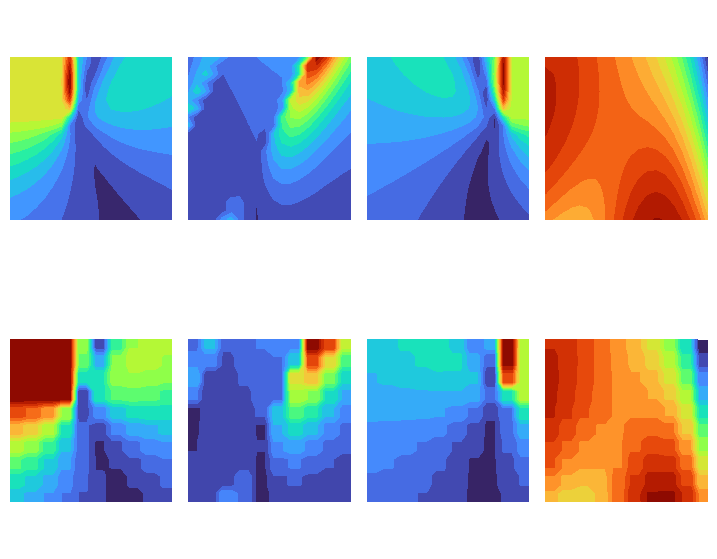

In [5]:
# display data
def cat_imshow(nx, ny, highreso_data, lowreso_data, super_resolution_data=None):
  plt.figure(figsize=(9, 7))
  for i in range(nx*ny):  # display X * Y data
    if i <= 3:
      velocity = highreso_data[i]
    elif i > 3 and i <= 7:
      velocity = lowreso_data[i-4]
    elif super_resolution_data != None:
      velocity = super_resolution_data[i-8]

    speed = np.sqrt(velocity[0,:,:]**2+velocity[1,:,:]**2)
    speed = speed.numpy()  # from Tensor to ndarray
    x = np.linspace(0,1,len(speed[:,0]))
    y = np.linspace(0,1,len(speed[0,:]))
    x, y = np.meshgrid(x,y)
    plt.subplot(nx, ny, i+1)
    plt.contourf(x, y, speed, cmap='turbo', levels=20)
    plt.axis('equal')
    plt.axis('off')  # delete scale
    plt.subplots_adjust(wspace=0.1, hspace=0.1)
  plt.show()

# check data
for highreso_data, lowreso_data in train_batch:
  cat_imshow(2, 4, highreso_data, lowreso_data)
  break

In [16]:
# define Group Convolutional Neural Network
class RotatedConv1(nn.Module):
  def __init__(self, in_channels, out_channels, kernel_size, stride, padding):
    super(RotatedConv1, self).__init__()
    self.conv = nn.Conv2d(in_channels, out_channels, kernel_size, stride, padding)
    self.stride = stride
    self.padding = padding

  def rotate_filter(self, k):
    return torch.rot90(self.conv.weight, k, dims=(2, 3))

  def forward(self, x):
    x1 = F.conv2d(x, self.rotate_filter(1), stride=self.stride, padding=self.padding)
    x2 = F.conv2d(x, self.rotate_filter(2), stride=self.stride, padding=self.padding)
    x3 = F.conv2d(x, self.rotate_filter(3), stride=self.stride, padding=self.padding)
    x4 = F.conv2d(x, self.rotate_filter(4), stride=self.stride, padding=self.padding)

    return x1,x2,x3,x4

class RotatedConv(nn.Module):
  def __init__(self, in_channels, out_channels, kernel_size, stride, padding):
    super(RotatedConv, self).__init__()
    self.conv = nn.Conv2d(in_channels, out_channels, kernel_size, stride, padding)
    self.stride = stride
    self.padding = padding

  def rotate_filter(self, k):
    return torch.rot90(self.conv.weight, k, dims=(2, 3))

  def forward(self, x):
    x1, x2, x3, x4 = x
    x1 = F.conv2d(x1, self.rotate_filter(1), stride=self.stride, padding=self.padding)
    x2 = F.conv2d(x2, self.rotate_filter(2), stride=self.stride, padding=self.padding)
    x3 = F.conv2d(x3, self.rotate_filter(3), stride=self.stride, padding=self.padding)
    x4 = F.conv2d(x4, self.rotate_filter(4), stride=self.stride, padding=self.padding)
    return x1,x2,x3,x4

class GCNN3(nn.Module):
  def __init__(self):
    super(GCNN3, self).__init__()
    self.conv1 = RotatedConv1(in_channels=2, out_channels=64, kernel_size=9, stride=1, padding=4)
    self.conv2 = RotatedConv(in_channels=64, out_channels=32, kernel_size=1, stride=1, padding=0)
    self.conv3 = RotatedConv(in_channels=32, out_channels=2, kernel_size=5, stride=1, padding=2)
  def forward(self, x):
    # Z2-P4 conv
    input_size = x[0,0,:,:].size()
    x1,x2,x3,x4 = self.conv1(x)
    # P4-P4 conv
    x1,x2,x3,x4 = self.conv2((x1,x2,x3,x4))
    x1,x2,x3,x4 = self.conv3((x1,x2,x3,x4))
    # pooling
    x1 = F.max_pool2d(x1, kernel_size=2, stride=1, padding=0)
    x2 = F.max_pool2d(x2, kernel_size=2, stride=1, padding=0)
    x3 = F.max_pool2d(x3, kernel_size=2, stride=1, padding=0)
    x4 = F.max_pool2d(x4, kernel_size=2, stride=1, padding=0)
    x = torch.max(torch.max(x1,x2),torch.max(x3,x4))
    # up-scaling
    x = F.interpolate(x,size=input_size, mode='bicubic',align_corners=False)
    return x

class GCNN5(nn.Module):
  def __init__(self):
    super(GCNN5, self).__init__()
    self.conv1 = RotatedConv1(in_channels=2, out_channels=64, kernel_size=9, stride=1, padding=4)
    self.conv2 = RotatedConv(in_channels=64, out_channels=64, kernel_size=9, stride=1, padding=4)
    self.conv3 = RotatedConv(in_channels=64, out_channels=64, kernel_size=9, stride=1, padding=4)
    self.conv4 = RotatedConv(in_channels=64, out_channels=32, kernel_size=9, stride=1, padding=4)
    self.conv5 = RotatedConv(in_channels=32, out_channels=2, kernel_size=5, stride=1, padding=2)
  def forward(self, x):
    # Z2-P4 conv
    input_size = x[0,0,:,:].size()
    x1,x2,x3,x4 = self.conv1(x)
    # P4-P4 conv
    x1,x2,x3,x4 = self.conv2((x1,x2,x3,x4))
    x1,x2,x3,x4 = self.conv3((x1,x2,x3,x4))
    x1,x2,x3,x4 = self.conv4((x1,x2,x3,x4))
    x1,x2,x3,x4 = self.conv5((x1,x2,x3,x4))
    # pooling
    x1 = F.max_pool2d(x1, kernel_size=2, stride=1, padding=0)
    x2 = F.max_pool2d(x2, kernel_size=2, stride=1, padding=0)
    x3 = F.max_pool2d(x3, kernel_size=2, stride=1, padding=0)
    x4 = F.max_pool2d(x4, kernel_size=2, stride=1, padding=0)
    x = torch.max(torch.max(x1,x2),torch.max(x3,x4))
    # up-scaling
    x = F.interpolate(x,size=input_size, mode='bicubic',align_corners=False)
    return x

class GCNN10(nn.Module):
  def __init__(self):
    super(GCNN10, self).__init__()
    self.conv1 = RotatedConv1(in_channels=2, out_channels=64, kernel_size=9, stride=1, padding=4)
    self.conv2 = RotatedConv(in_channels=64, out_channels=64, kernel_size=9, stride=1, padding=4)
    self.conv3 = RotatedConv(in_channels=64, out_channels=64, kernel_size=9, stride=1, padding=4)
    self.conv4 = RotatedConv(in_channels=64, out_channels=64, kernel_size=9, stride=1, padding=4)
    self.conv5 = RotatedConv(in_channels=64, out_channels=64, kernel_size=9, stride=1, padding=4)
    self.conv6 = RotatedConv(in_channels=64, out_channels=64, kernel_size=9, stride=1, padding=4)
    self.conv7 = RotatedConv(in_channels=64, out_channels=64, kernel_size=9, stride=1, padding=4)
    self.conv8 = RotatedConv(in_channels=64, out_channels=64, kernel_size=9, stride=1, padding=4)
    self.conv9 = RotatedConv(in_channels=64, out_channels=32, kernel_size=9, stride=1, padding=4)
    self.conv10 = RotatedConv(in_channels=32, out_channels=2, kernel_size=5, stride=1, padding=2)
  def forward(self, x):
    # Z2-P4 conv
    input_size = x[0,0,:,:].size()
    x1,x2,x3,x4 = self.conv1(x)
    # P4-P4 conv
    x1,x2,x3,x4 = self.conv2((x1,x2,x3,x4))
    x1,x2,x3,x4 = self.conv3((x1,x2,x3,x4))
    x1,x2,x3,x4 = self.conv4((x1,x2,x3,x4))
    x1,x2,x3,x4 = self.conv5((x1,x2,x3,x4))
    x1,x2,x3,x4 = self.conv6((x1,x2,x3,x4))
    x1,x2,x3,x4 = self.conv7((x1,x2,x3,x4))
    x1,x2,x3,x4 = self.conv8((x1,x2,x3,x4))
    x1,x2,x3,x4 = self.conv9((x1,x2,x3,x4))
    x1,x2,x3,x4 = self.conv10((x1,x2,x3,x4))
    # pooling
    x1 = F.max_pool2d(x1, kernel_size=2, stride=1, padding=0)
    x2 = F.max_pool2d(x2, kernel_size=2, stride=1, padding=0)
    x3 = F.max_pool2d(x3, kernel_size=2, stride=1, padding=0)
    x4 = F.max_pool2d(x4, kernel_size=2, stride=1, padding=0)
    x = torch.max(torch.max(x1,x2),torch.max(x3,x4))
    # up-scaling
    x = F.interpolate(x,size=input_size, mode='bicubic',align_corners=False)
    return x

In [13]:
def trainNN(net,optimizer,criterion,train_batch,test_batch,epoch):
  # make lists to store MSE
  train_loss_list = []
  test_loss_list = []

  # do machine learning
  for i in range(epoch):
    # progress var
    print('---------------------------------------------')
    print("Epoch: {}/{}".format(i+1, epoch))

    # initialize loss
    train_loss = 0
    test_loss = 0

    # train NN
    net.train()
    # load mini batch
    for highreso_data, lowreso_data in train_batch:
      # transfer Tensor to GPU
      highreso_data = highreso_data.to(device)
      lowreso_data = lowreso_data.to(device)
      # initialize grad
      optimizer.zero_grad()
      # calc pred
      y_pred = net(lowreso_data)
      # calc loss
      loss = criterion(y_pred, highreso_data)
      # calc grad
      loss.backward()
      # update parameters
      optimizer.step()
      # stock train loss
      train_loss += loss.item()

    # calc mean loss
    batch_train_loss = train_loss / len(train_batch)

    # evaluate NN
    net.eval()
    with torch.no_grad():
      for highreso_data, lowreso_data in test_batch:
        # transfer Tensor to GPU
        highreso_data = highreso_data.to(device)
        lowreso_data = lowreso_data.to(device)
        # calc pred
        y_pred = net(lowreso_data)
        # calc loss
        loss = criterion(y_pred, highreso_data)
        # stock test loss
        test_loss += loss.item()

    # calc mean loss
    batch_test_loss = test_loss / len(test_batch)

    print("Train_Loss: {:.4f}".format(batch_train_loss))
    print("Test_Loss: {:.4f}".format(batch_test_loss))

    train_loss_list.append(batch_train_loss)
    test_loss_list.append(batch_test_loss)
  return net, train_loss_list, test_loss_list

<class '__main__.GCNN3'>
Device: cuda
---------------------------------------------
Epoch: 1/100
Train_Loss: 0.2945
Test_Loss: 0.1881
---------------------------------------------
Epoch: 2/100
Train_Loss: 0.1271
Test_Loss: 0.1038
---------------------------------------------
Epoch: 3/100
Train_Loss: 0.0898
Test_Loss: 0.0813
---------------------------------------------
Epoch: 4/100
Train_Loss: 0.0709
Test_Loss: 0.0644
---------------------------------------------
Epoch: 5/100
Train_Loss: 0.0634
Test_Loss: 0.0596
---------------------------------------------
Epoch: 6/100
Train_Loss: 0.0582
Test_Loss: 0.0562
---------------------------------------------
Epoch: 7/100
Train_Loss: 0.0551
Test_Loss: 0.0560
---------------------------------------------
Epoch: 8/100
Train_Loss: 0.0532
Test_Loss: 0.0517
---------------------------------------------
Epoch: 9/100
Train_Loss: 0.0518
Test_Loss: 0.0504
---------------------------------------------
Epoch: 10/100
Train_Loss: 0.0516
Test_Loss: 0.0558
-

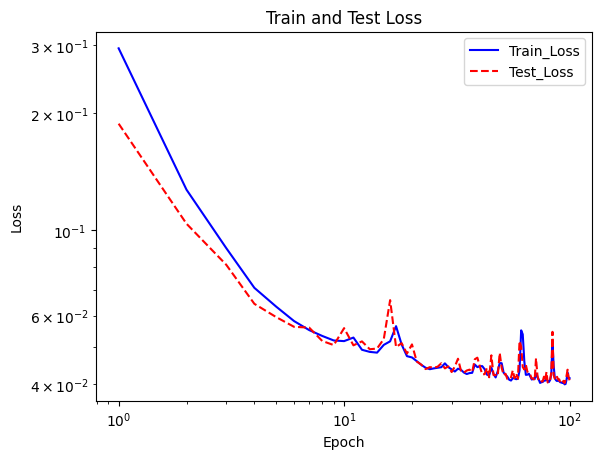

In [14]:
# use GPU
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
net3 = GCNN3().to(device)   # choose GCNN
print(GCNN3)
# check device
print("Device: {}".format(device))

# define loss function
criterion = nn.MSELoss()

# define optimizer
optimizer = optim.Adam(net3.parameters())

# define epoch
epoch = 100

net3, train_loss_list, test_loss_list = trainNN(net3,optimizer,criterion,train_batch,test_batch,epoch)

# loss（MSE）
plt.figure()
plt.title('Train and Test Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.plot(range(1, epoch+1), train_loss_list, color='blue',
         linestyle='-', label='Train_Loss')
plt.plot(range(1, epoch+1), test_loss_list, color='red',
         linestyle='--', label='Test_Loss')
plt.legend()
plt.xscale('log')
plt.yscale('log')
plt.show()

<class '__main__.GCNN5'>
Device: cuda
---------------------------------------------
Epoch: 1/100
Train_Loss: 25.1668
Test_Loss: 4.6291
---------------------------------------------
Epoch: 2/100
Train_Loss: 3.0033
Test_Loss: 1.3289
---------------------------------------------
Epoch: 3/100
Train_Loss: 0.7926
Test_Loss: 0.4849
---------------------------------------------
Epoch: 4/100
Train_Loss: 0.3306
Test_Loss: 0.2818
---------------------------------------------
Epoch: 5/100
Train_Loss: 0.2161
Test_Loss: 0.1877
---------------------------------------------
Epoch: 6/100
Train_Loss: 0.1625
Test_Loss: 0.1526
---------------------------------------------
Epoch: 7/100
Train_Loss: 0.1368
Test_Loss: 0.1314
---------------------------------------------
Epoch: 8/100
Train_Loss: 0.1205
Test_Loss: 0.1211
---------------------------------------------
Epoch: 9/100
Train_Loss: 0.1101
Test_Loss: 0.1097
---------------------------------------------
Epoch: 10/100
Train_Loss: 0.1022
Test_Loss: 0.1025


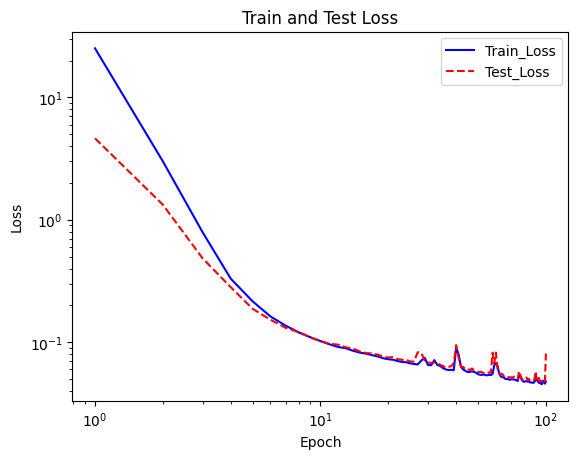

In [17]:
# use GPU
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
net5 = GCNN5().to(device)   # choose GCNN
print(GCNN5)
# check device
print("Device: {}".format(device))

# define loss function
criterion = nn.MSELoss()

# define optimizer
optimizer = optim.Adam(net5.parameters())

# define epoch
epoch = 100

net5, train_loss_list, test_loss_list = trainNN(net5,optimizer,criterion,train_batch,test_batch,epoch)

# loss（MSE）
plt.figure()
plt.title('Train and Test Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.plot(range(1, epoch+1), train_loss_list, color='blue',
         linestyle='-', label='Train_Loss')
plt.plot(range(1, epoch+1), test_loss_list, color='red',
         linestyle='--', label='Test_Loss')
plt.legend()
plt.xscale('log')
plt.yscale('log')
plt.show()

<class '__main__.GCNN10'>
Device: cuda
---------------------------------------------
Epoch: 1/100
Train_Loss: 2506579.1788
Test_Loss: 914278.5625
---------------------------------------------
Epoch: 2/100
Train_Loss: 8300221.0195
Test_Loss: 93524329.0000
---------------------------------------------
Epoch: 3/100
Train_Loss: 235320778.8457
Test_Loss: 265299340.0000
---------------------------------------------
Epoch: 4/100
Train_Loss: 11739867364.5000
Test_Loss: 264329957376.0000
---------------------------------------------
Epoch: 5/100
Train_Loss: 7445727564800.0000
Test_Loss: 437440078675968.0000
---------------------------------------------
Epoch: 6/100
Train_Loss: 22943583555223552.0000
Test_Loss: 4006984504311808.0000
---------------------------------------------
Epoch: 7/100
Train_Loss: 12947785855795200.0000
Test_Loss: 67354521239552.0000
---------------------------------------------
Epoch: 8/100
Train_Loss: 3417506767437824.0000
Test_Loss: 3515502873804800.0000
----------------

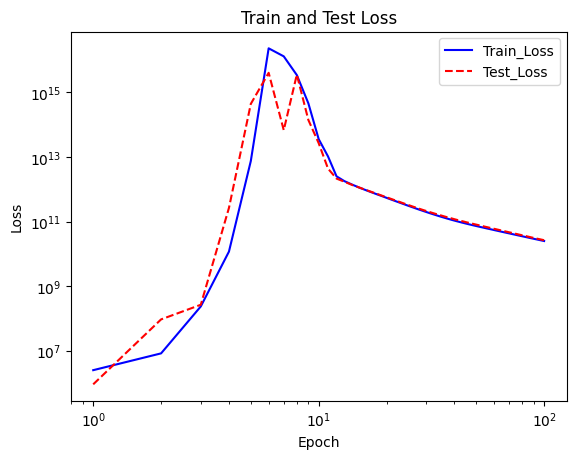

In [18]:
# use GPU
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
net10 = GCNN10().to(device)   # choose GCNN
print(GCNN10)
# check device
print("Device: {}".format(device))

# define loss function
criterion = nn.MSELoss()

# define optimizer
optimizer = optim.Adam(net10.parameters())

# define epoch
epoch = 100

net10, train_loss_list, test_loss_list = trainNN(net10,optimizer,criterion,train_batch,test_batch,epoch)

# loss（MSE）
plt.figure()
plt.title('Train and Test Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.plot(range(1, epoch+1), train_loss_list, color='blue',
         linestyle='-', label='Train_Loss')
plt.plot(range(1, epoch+1), test_loss_list, color='red',
         linestyle='--', label='Test_Loss')
plt.legend()
plt.xscale('log')
plt.yscale('log')
plt.show()

3 layers


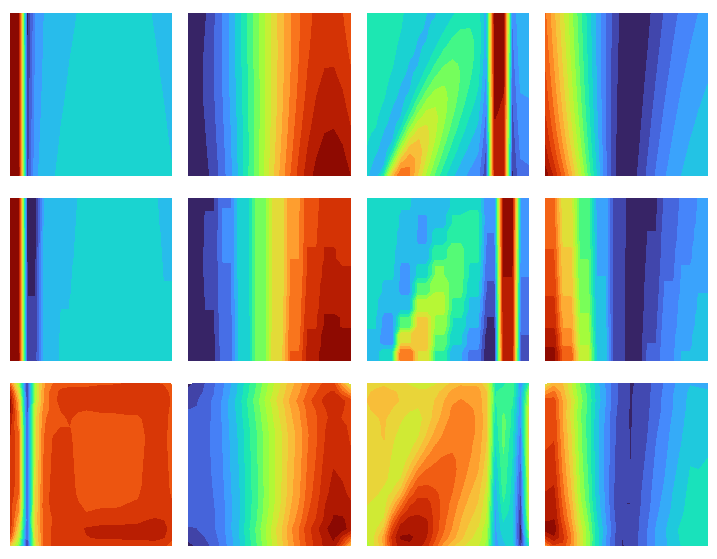

In [19]:
# check super-resolution data
# 3 layers
print("3 layers")
net3.eval()
with torch.no_grad():
  for highreso_data, lowreso_data in test_batch:
    # transfer Tensor to GPU
    highreso_data = highreso_data.to(device)
    lowreso_data = lowreso_data.to(device)
    # calc pred
    y_pred = net3(lowreso_data)
    # show result
    cat_imshow(3, 4, highreso_data.to('cpu'), lowreso_data.to('cpu'), y_pred.to('cpu'))
    plt.show()
    break

5 layers


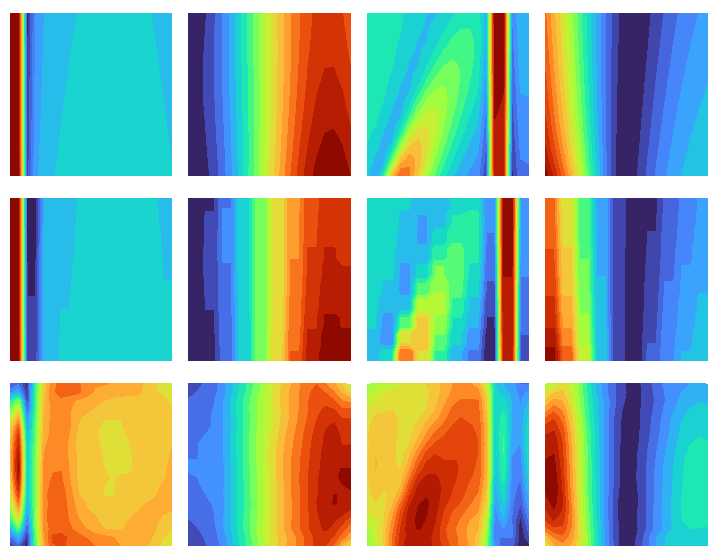

In [20]:
# check super-resolution data
# 5 layers
print("5 layers")
net5.eval()
with torch.no_grad():
  for highreso_data, lowreso_data in test_batch:
    # transfer Tensor to GPU
    highreso_data = highreso_data.to(device)
    lowreso_data = lowreso_data.to(device)
    # calc pred
    y_pred = net5(lowreso_data)
    # show result
    cat_imshow(3, 4, highreso_data.to('cpu'), lowreso_data.to('cpu'), y_pred.to('cpu'))
    plt.show()
    break

10 layers


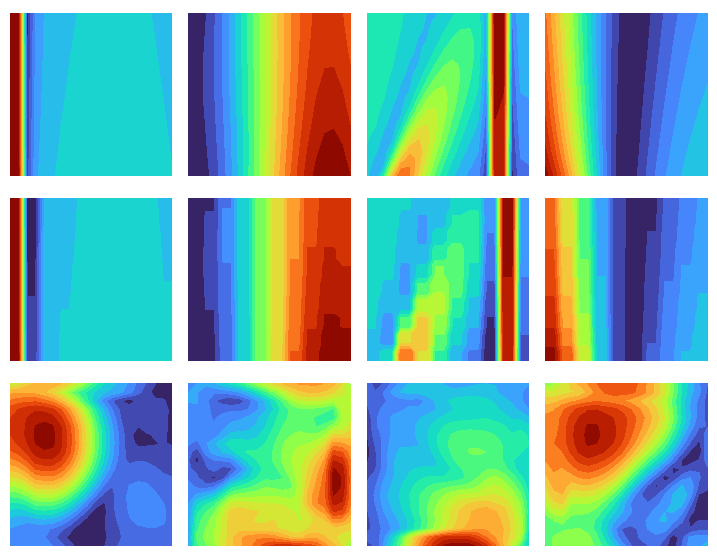

In [21]:
# check super-resolution data
# 10 layers
print("10 layers")
net10.eval()
with torch.no_grad():
  for highreso_data, lowreso_data in test_batch:
    # transfer Tensor to GPU
    highreso_data = highreso_data.to(device)
    lowreso_data = lowreso_data.to(device)
    # calc pred
    y_pred = net10(lowreso_data)
    # show result
    cat_imshow(3, 4, highreso_data.to('cpu'), lowreso_data.to('cpu'), y_pred.to('cpu'))
    plt.show()
    break